# Treinamento SVM

### Instalação de Requirements

In [ ]:
! pip install -U scikit-learn
! pip install matplotlib
! pip install pyarrow
! pip install fastparquet

## Bibliotecas que devem ser importadas

Pandas para manipulação de dados, SVC para construir o modelo de classificação, além de diversos métodos do scikit-learn para avaliação do modelo.

In [14]:
from sklearn.datasets import make_circles
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import numpy as np
import itertools

## Carregar e Balancear o Conjunto de Dados

In [15]:
df = pd.read_parquet("../data/processed/sim_2006_2017_pre_processed.parquet")

In [16]:
suicidio_0 = df[df['SUICIDIO'] == 0]
suicidio_1 = df[df['SUICIDIO'] == 1]

suicidio_0_sample = suicidio_0.sample(n=len(suicidio_1), replace=False)
balanced_df = pd.concat([suicidio_0_sample, suicidio_1], ignore_index=True).reset_index(drop=True)

## Preparar Dados para Treinamento

Características e variável alvo do DataFrame balanceado são selecionadas, seguido pela divisão dos dados em conjuntos de treinamento e teste para avaliar o desempenho do modelo posteriormente.

In [17]:
X = balanced_df[['ESC', 'ESTCIV',     'NATURAL' ,    'OCUP',    'RACACOR'    ,'MASCULINO',    'FEMININO'    ]].values
y = balanced_df['SUICIDIO'].values

### Divisão entre teste e treino


In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Treinar o modelo Support Vector Machine

O Support Vector Machine (SVM) é um modelo de aprendizado de máquina amplamente usado para classificação reconhecido pela sua eficácia em encontrar a melhor divisão linear entre categorias de dados
Têm capacidade de maximizar a separação entre classes, proporcionando um modelo robusto e eficiente para problemas de classificação.

In [19]:
modelo_svm = SVC(kernel="rbf")
modelo_svm.fit(X_train, y_train)

SVC()

### Realizar previsões com o Modelo

In [20]:
y_pred = modelo_svm.predict(X_test)

## Avaliar o Modelo

In [21]:
print("Relatório de Classificação SVM: \n",
      classification_report(y_test, y_pred))
print("Matriz de Confusão do SVM:\n", confusion_matrix(y_test, y_pred))

Relatório de Classificação SVM: 
               precision    recall  f1-score   support

           0       0.68      0.44      0.53      4745
           1       0.58      0.79      0.67      4688

    accuracy                           0.61      9433
   macro avg       0.63      0.62      0.60      9433
weighted avg       0.63      0.61      0.60      9433

Matriz de Confusão do SVM:
 [[2090 2655]
 [ 984 3704]]


## Visualização dos dados

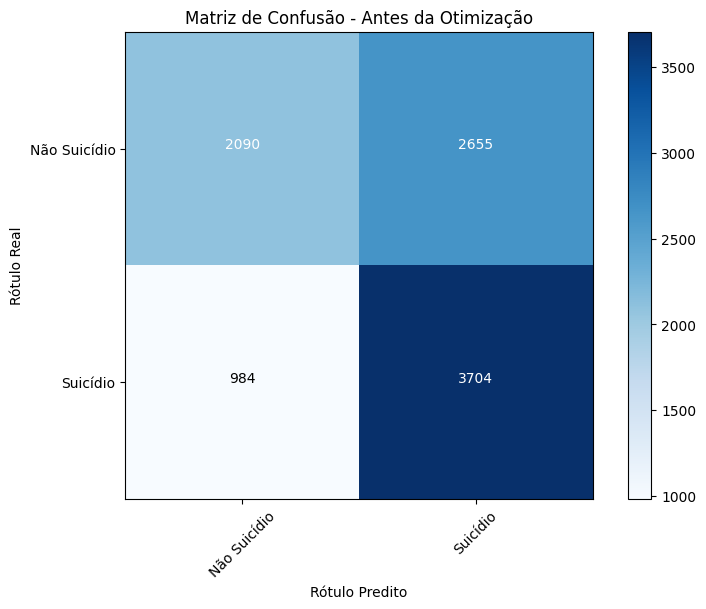

In [22]:
# Calcular a matriz de confusão
cm = confusion_matrix(y_test, y_pred)

# Plotar a matriz de confusão
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Matriz de Confusão - Antes da Otimização')
plt.colorbar()
tick_marks = np.arange(len(['Não Suicídio', 'Suicídio']))
plt.xticks(tick_marks, ['Não Suicídio', 'Suicídio'], rotation=45)
plt.yticks(tick_marks, ['Não Suicídio', 'Suicídio'])
plt.tight_layout()
plt.ylabel('Rótulo Real')
plt.xlabel('Rótulo Predito')

# Adicionar os valores nas células da matriz
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.show()

In [26]:
# Adicionando mais exemplos de teste ao DataFrame
teste = pd.DataFrame({
    'ESC': [5, 5, 4, 4, 3], 
    'ESTCIV': [1, 1, 2, 2, 3], 
    'IDADE': [22, 21, 34, 34, 25], 
    'NATURAL': [53, 52, 29, 29, 35], 
    'OCUP': [-1, -1, 5132, 5132, 1200], 
    'RACACOR': [4, 1, 4, 4, 2], 
    'MASCULINO': [False, True, True, True, False], 
    'FEMININO': [True, False, False, False, True]
})

std = StandardScaler()

# Padronizando os dados
columns = ['ESC', 'ESTCIV',  'OCUP', 'RACACOR']
teste[columns] = std.fit_transform(teste[columns])

# Obtendo os valores para previsão
x = teste[['ESC', 'ESTCIV',  'NATURAL', 'OCUP', 'RACACOR', 'MASCULINO', 'FEMININO']].values

# Fazendo previsões
y_pred = modelo_svm.predict(x)
y_pred

array([1, 1, 1, 1, 0], dtype=int64)

# Otimização e ajuste fino do sistema

In [31]:
# Definir os hiperparâmetros a serem testados
param_grid = {
    'C': [1],
    'gamma': ['scale', 'auto'],
}

In [32]:
grid_search = GridSearchCV(estimator=SVC(kernel="rbf"),
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=5,
                           n_jobs=-1)

grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [1], 'gamma': ['scale', 'auto']},
             scoring='accuracy')

In [33]:
# Imprimir os melhores hiperparâmetros encontrados
print("Melhores hiperparâmetros encontrados:")
print(grid_search.best_params_)

# Realizar previsões com o modelo ajustado
y_pred = grid_search.predict(X_test)

# Avaliar o modelo
print("Relatório de Classificação:")
print(classification_report(y_test, y_pred))
print("Matriz de Confusão:")
print(confusion_matrix(y_test, y_pred))

Melhores hiperparâmetros encontrados:
{'C': 1, 'gamma': 'auto'}
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.71      0.69      0.70      4745
           1       0.69      0.71      0.70      4688

    accuracy                           0.70      9433
   macro avg       0.70      0.70      0.70      9433
weighted avg       0.70      0.70      0.70      9433

Matriz de Confusão:
[[3259 1486]
 [1355 3333]]


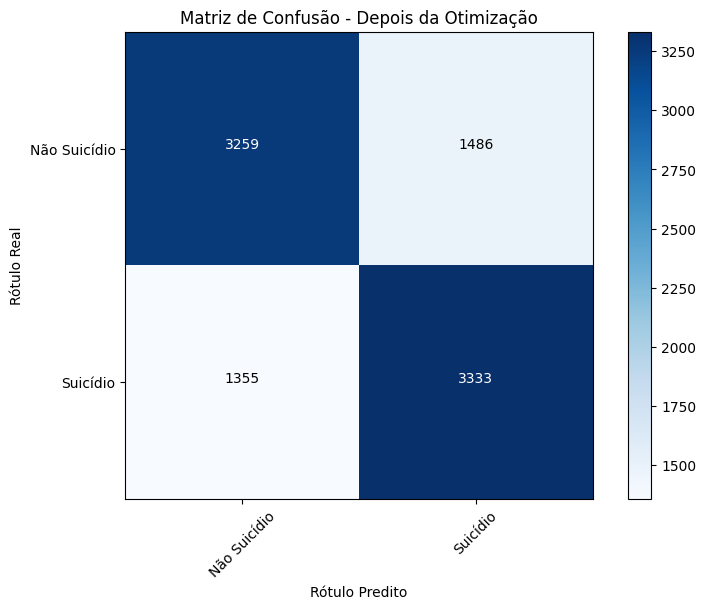

In [34]:
# Calcular a matriz de confusão
cm = confusion_matrix(y_test, y_pred)

# Plotar a matriz de confusão
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Matriz de Confusão - Depois da Otimização')
plt.colorbar()
tick_marks = np.arange(len(['Não Suicídio', 'Suicídio']))
plt.xticks(tick_marks, ['Não Suicídio', 'Suicídio'], rotation=45)
plt.yticks(tick_marks, ['Não Suicídio', 'Suicídio'])
plt.tight_layout()
plt.ylabel('Rótulo Real')
plt.xlabel('Rótulo Predito')

# Adicionar os valores nas células da matriz
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.show()

In [39]:
# Adicionando mais exemplos de teste ao DataFrame
teste = pd.DataFrame({
    'ESC': [5, 5, 4, 4, 3], 
    'ESTCIV': [1, 1, 2, 2, 3], 
    'IDADE': [22, 21, 34, 34, 25], 
    'NATURAL': [53, 52, 29, 29, 35], 
    'OCUP': [-1, -1, 5132, 5132, 1200], 
    'RACACOR': [4, 1, 4, 4, 2], 
    'MASCULINO': [False, True, True, True, False], 
    'FEMININO': [True, False, False, False, True]
})

std = StandardScaler()

# Padronizando os dados
columns = ['ESC', 'ESTCIV',  'OCUP', 'RACACOR']
teste[columns] = std.fit_transform(teste[columns])

# Obtendo os valores para previsão
x = teste[['ESC', 'ESTCIV',  'NATURAL', 'OCUP', 'RACACOR', 'MASCULINO', 'FEMININO']].values

# Fazendo previsões
y_pred = grid_search.predict(x)
y_pred


array([1, 1, 0, 0, 1], dtype=int64)